# One versus all as a anomaly detection problem on CIFAR10

Inspired from Ruff 2018.

In this study, we train each our model to identify one of the ten digits in the MNIST dataset. All the other digits are considered as "outliers" ; they are not seen during training, and during evaluation the model has to predict if an image is in the normal class or in the outlier class.

This evaluation method will be our standard to test the performances of a model. We will use the classification metrics ROC-AUC to measure the performance of a model and compare them with pre-existing methods.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

# # DRIVE
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

from uad.callbacks.metrics import AUCCallback, PrecisionRecallCallback
from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.models.variational_autoencoder import ConvolutionalVAE
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC

!nvidia-smi

2.2.0


Using TensorFlow backend.
'nvidia-smi' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


## Import data

In [2]:
x_train = np.concatenate([np.load(f"dataset/data_batch_{i}.npy") for i in range(1, 5)], axis=0)
x_val = np.load("dataset/data_batch_5.npy")
x_test = np.load("dataset/data_test_batch.npy")
y_train = np.concatenate([np.load(f"dataset/labels_batch_{i}.npy") for i in range(1, 5)], axis=0)
y_val = np.load("dataset/labels_batch_5.npy")
y_test = np.load("dataset/labels_test_batch.npy")

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

x_train = x_train / 255
x_test = x_train / 255

interest_digit = 0

y_val = binarize_set(y_val, interest=interest_digit)

# train set sorted by digits: digits_train[i] = x_train elements where y_train == i
digits_train = np.array([x_train[np.where(y_train[:] == i)] for i in range(10)])

# training set contains only zeros (for training on zeros)
labels_bin = binarize_set(y_train, interest=interest_digit)
x_train_bin, y_train_bin = digits_train[interest_digit], y_train[np.where(y_train == interest_digit)]
y_test_bin = binarize_set(y_test, interest=interest_digit)

print(x_train_bin.shape, y_train_bin.shape)

(40000, 32, 32, 3) (40000,) (10000, 32, 32, 3) (10000,) (10000, 3072) (10000,)
(3986, 32, 32, 3) (3986,)


## Build model

For this introduction, the model will learn to reconstruct the digit 0.

In [ ]:
latent_side = 4

encoder_inputs = layers.Input(shape=(28, 28, 1), name="encoder_inputs")

paddings = tf.constant([[0, 0], [2, 2], [2, 2], [0,
                                                 0]])  # shape d x 2 where d is the rank of the tensor and 2 represents "before" and "after"
x = tf.pad(encoder_inputs, paddings, name="pad")

# contracting path
x = self.conv2d_block(x, n_filters * 1, kernel_size=k_size, batchnorm=batchnorm)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(dropout)(x)

x = self.conv2d_block(x, n_filters * 2, kernel_size=k_size, batchnorm=batchnorm)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(dropout)(x)

x = self.conv2d_block(x, n_filters=n_filters * 4, kernel_size=k_size, batchnorm=batchnorm)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(dropout)(x)

z_mean = layers.Conv2D(latent_dim, 1, strides=1, name="z_mean")(x)
z_log_var = layers.Conv2D(latent_dim, 1, strides=1, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))

self.encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Define decoder model.
latent_inputs = layers.Input(shape=(latent_side, latent_side, latent_dim), name="z_sampling")

x = layers.Conv2DTranspose(n_filters * 4, (k_size, k_size), strides=(2, 2), padding='same', name="u6")(
    latent_inputs)
x = layers.Dropout(dropout)(x)
x = self.conv2d_block(x, n_filters * 4, kernel_size=k_size, batchnorm=batchnorm)

x = layers.Conv2DTranspose(n_filters * 2, (k_size, k_size), strides=(2, 2), padding='same', name="u7")(x)
x = layers.Dropout(dropout)(x)
x = self.conv2d_block(x, n_filters * 2, kernel_size=k_size, batchnorm=batchnorm)

x = layers.Conv2DTranspose(n_filters * 1, (k_size, k_size), strides=(2, 2), padding='same', name="u8")(x)
x = layers.Dropout(dropout)(x)
decoder_outputs = self.conv2d_block(x, 1, kernel_size=k_size, batchnorm=batchnorm)
crop = tf.image.resize_with_crop_or_pad(decoder_outputs, 28, 28)

self.decoder = Model(inputs=latent_inputs, outputs=crop, name="decoder")

In [21]:
# from uad.models.variational_autoencoder import ConvolutionalVAE

latent_dim = 16

auc_callback = AUCCallback(x_val, y_val_bin)
val_acc_callback = PrecisionRecallCallback(x_val, y_val_bin, prefix="val")
train_acc_callback = PrecisionRecallCallback(x_train[:2000], labels_bin[:2000], prefix="train")

vae = ConvolutionalVAE(2)

vae.compile(optimizer=tf.keras.optimizers.Adam())

In [22]:
history = vae.fit(x_train_bin, x_train_bin, validation_data=(x_val, y_val_bin), epochs=10, batch_size=128, callbacks=[train_acc_callback, val_acc_callback])


Epoch 1/10
38/38 [==============================] - ETA: 0s - loss: 343.2024 - reconstruction_loss: 343.0925 - kl_loss: 0.1098 - train_accuracy: 90.10000228881836%
 - train_recall: 100.0%
 - val_accuracy: 89.49999809265137%
 - val_recall: 100.0%
38/38 [==============================] - 16s 413ms/step - loss: 342.6728 - reconstruction_loss: 342.5581 - kl_loss: 0.1147 - val_reconstruction_loss: 281.1760 - train_precision: 90.1000 - train_recall: 100.0000 - val_precision: 89.5000 - val_recall: 100.0000
Epoch 2/10
38/38 [==============================] - ETA: 0s - loss: 281.3031 - reconstruction_loss: 280.7277 - kl_loss: 0.5754 - train_accuracy: 90.10000228881836%
 - train_recall: 100.0%
 - val_accuracy: 89.49999809265137%
 - val_recall: 100.0%
38/38 [==============================] - 15s 405ms/step - loss: 279.9005 - reconstruction_loss: 279.3074 - kl_loss: 0.5931 - val_reconstruction_loss: 213.7140 - train_precision: 90.1000 - train_recall: 100.0000 - val_precision: 89.5000 - val_recall:

Precision is always: 90%, from the beginning. This is because we have a huge class imbalance: a network that predicts 1 (anomaly) randomly will have 90% accuracy! This is why precision is not so pertinent in our case. Same for recall: it is 100% which means that there is no false negative. Indeed in the beginning of training, reconstruction loss (on which is based anomaly prediction) is so huge that each image is considered as abnormal. As a consequence, no false positives at all.

(3, 2)


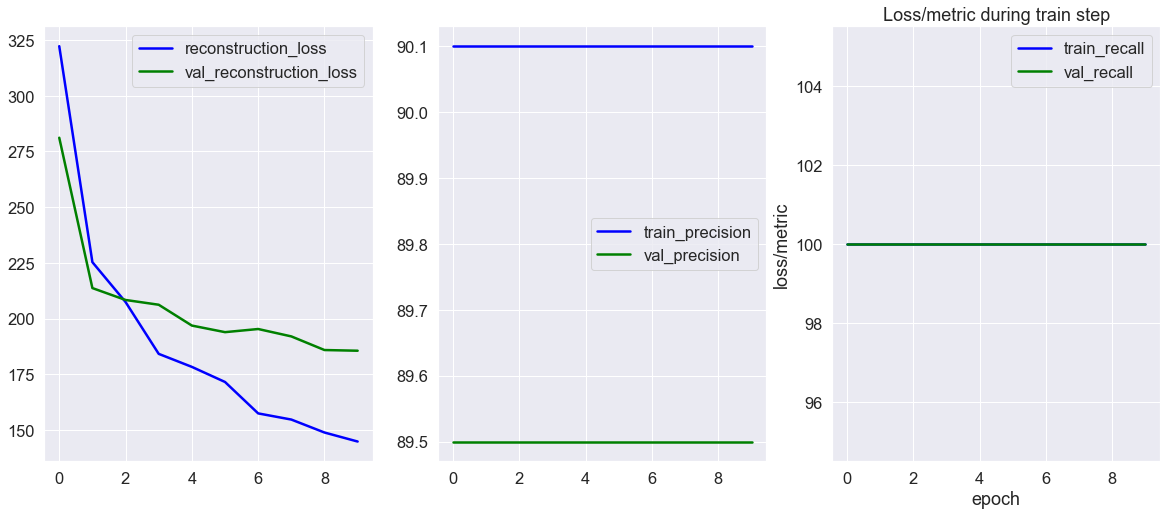

In [30]:
from uad.diagnostic.metrics import plot_history

metrics = np.array([["reconstruction_loss", "val_reconstruction_loss"], ["train_precision", "val_precision"], ["train_recall", "val_recall"]])

print(metrics.shape)

f, ax = plot_history(history, metric_names=metrics)

In [26]:
# tf.keras.models.save_model(vae, "saved_models/vae_4x4x16_trained_0")

In [ ]:
import os
os.chdir("/content/gdrive/My Drive/BACMMAN_DISTNET/UAD/MNIST/saved_models")

vae = tf.keras.models.load_model("vae_16_3")

In [ ]:
vae_predictions = vae.predict(x_test)

# Predictions analysis

We take the following convention: the positive class is constituted of the anomalous items. A wrongly predicted anormal digit is considered as a false positive. 

### Plot single item

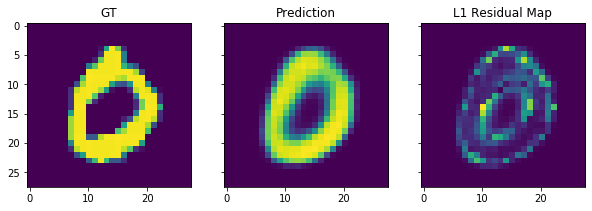

In [ ]:
if vae_predictions.shape == (vae_predictions.shape[0], 28, 28, 1):
    vae_predictions = np.squeeze(vae_predictions, axis=-1)
    
if x_test.shape == (x_test.shape[0], 28, 28, 1):
    x_test_im = np.squeeze(x_test, axis=-1)
else:
    x_test_im = x_test

idx = 3

fig, ax = plot_prediction(x_test_im[idx], vae_predictions[idx])

## Plot t-SNE visualisation of latent space



t-SNE inputs shape: (10000, 784)
t-SNE inputs shape: (10000, 28)
t-SNE inputs shape: (10000, 28)
t-SNE inputs shape: (10000, 1)


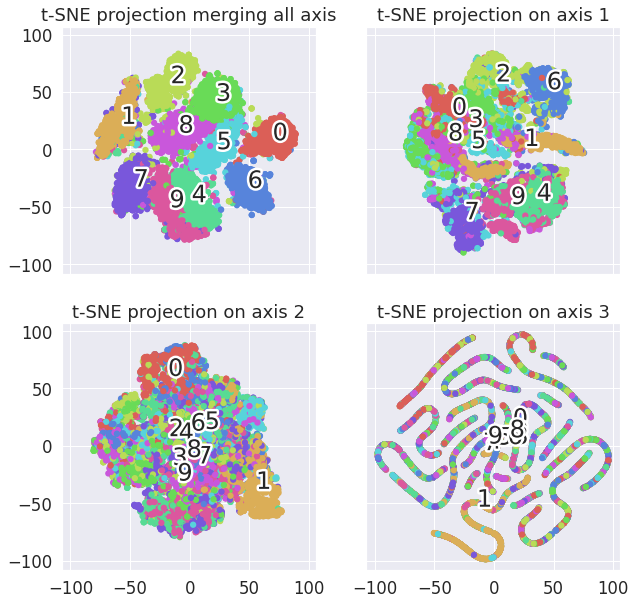

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(10, 10), sharex="all", sharey="all")

for i, ax in enumerate(axis.flatten()):
  plot_tSNE(x_test, y_test, axis=i, plt_ax=ax)
  if i == 0:
    ax.set_title(f"t-SNE projection merging all axis")
  else:
    ax.set_title(f"t-SNE projection on axis {i}")

## Plot 2D-PCA

In order to visualise the latent space embedding, we can use another dimensionality reduction method: PCA

In [ ]:
def compute_PCA(dataset, n_dims=2, desired_axis=-1):
    """
    Performs PCA on the given dataset, along the desired axis and outputs the result
    vectors with the given dimen. If a third-rank is given, takes the mean of the other axis, to get a final vector
    along the desired axis (since t-SNE only takes vectors as inputs and we don't
    want to mix the different axis)
    :param dataset: np.array
    :param desired_axis: axis on which to project the dataset (e.g. to project
    on channels : axis=-1 in channels_last configuration). None or 0 if you want to
    merge all axis in one.
    :return: an array containing the same number of items than in the given
    dataset but with the output dimension of the t-SNE transformation
    """
    if len(dataset.shape) > 2:  # third-rank tensor or matrix
        if desired_axis is None or desired_axis == 0:
            if len(dataset.shape) == 4:
                batch, x, y, z = dataset.shape
                dataset = np.reshape(dataset, (batch, x * y * z))
            elif len(dataset.shape) == 3:
                batch, x, y = dataset.shape
                dataset = np.reshape(dataset, (batch, x * y))
            else:
                raise NotImplementedError("Input dataset should be a batch of 3 or 2-rank tensors at most")
        else:  # merge only non desired axis by taking the mean along each
            axes = range(len(dataset.shape))
            axes = np.delete(axes, desired_axis)
            axes = np.delete(axes, 0)  # keep first axis (individual elements)
            while axes != []:
                dataset = np.mean(dataset, axis=axes[0])  # perform mean along the non-desired axis
                axes = [a - 1 for a in axes]
                del axes[0]
    print(f"PCA inputs shape: {dataset.shape}")
    return PCA(n_components=n_dims).fit_transform(dataset)


def plot_PCA(dataset, colors, axis=-1, n_dims=2, plot_center={"bary": False, "center": False}, plt_ax=None):
    """
    Plot the PCA projection of a given dataset
    :param dataset: input images
    :param colors: original labels which serve as colors
    :param plot_center:
    :param axis: axis along which to perform t-SNE
    :param plt_ax: matplotlib axis object on which to plot the result
    :return: matplotlib figure, axis, scatter and texts
    """
    x = compute_PCA(dataset, n_dims=n_dims, desired_axis=axis)

    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))
    #     palette = np.array(colors)

    if n_dims == 2:
      # create a scatter plot.
      if plt_ax is None:
          f = plt.figure(figsize=(8, 8))
          plt_ax = plt.subplot(aspect='equal')
          sc = plt_ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(np.int)])
          plt.xlim(-25, 25)
          plt.ylim(-25, 25)
          plt_ax.axis('on')
          plt_ax.axis('tight')
      else:
          f = None
          sc = plt_ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(np.int)])
          plt.xlim(-25, 25)
          plt.ylim(-25, 25)
          plt_ax.axis('on')
          plt_ax.axis('tight')

      # add the labels for each digit corresponding to the label
      txts = []

      for i in range(num_classes):
          # Position of each label at median of data points.

          xtext, ytext = np.median(x[colors == i, :], axis=0)
          txt = plt_ax.text(xtext, ytext, str(i), fontsize=24)
          txt.set_path_effects([
              PathEffects.Stroke(linewidth=5, foreground="w"),
              PathEffects.Normal()])
          txts.append(txt)

      # plot the center
      if np.any(plot_center["bary"]):
          plt_ax.plot(plot_center["bary"][0], plot_center["bary"][1], "x", c="r", markersize=18)
          plt_ax.text(plot_center["bary"][0], plot_center["bary"][1], "bary", fontsize=20)
      if np.any(plot_center["center"]):
          plt_ax.plot(plot_center["center"][0], plot_center["center"][1], "x", c="b", markersize=18)
          plt_ax.text(plot_center["center"][0], plot_center["center"][1], "center", fontsize=20)
    
    elif n_dims == 3:
      if plt_ax is None:
          f = plt.figure(figsize=(8, 8))
          plt_ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
          sc = plt_ax.scatter(x[:, 0], x[:, 1], x[:, 2], s=40, lw=0, c=palette[colors.astype(np.int)])
          plt.xlim(-25, 25)
          plt.ylim(-25, 25)
          plt_ax.axis('on')
          plt_ax.axis('tight')
      else:
          f = None
          sc = plt_ax.scatter(x[:, 0], x[:, 1], x[:, 2], s=40, lw=0, c=palette[colors.astype(np.int)])
          plt.xlim(-25, 25)
          plt.ylim(-25, 25)
          plt_ax.axis('on')
          plt_ax.axis('tight')

      # add the labels for each digit corresponding to the label
      txts = []

      for i in range(num_classes):
          # Position of each label at median of data points.

          xtext, ytext, ztext = np.median(x[colors == i, :], axis=0)
          txt = plt_ax.text(xtext, ytext, ztext, str(i), fontsize=24)
          txt.set_path_effects([
              PathEffects.Stroke(linewidth=5, foreground="w"),
              PathEffects.Normal()])
          txts.append(txt)

    else:
      raise NotImplementedError("Output dimension should be either 2 or 3")

    return f, plt_ax, sc, txts

In [ ]:
z_means, z_log_vars, _ = vae.encoder.predict(x_test)

PCA inputs shape: (10000, 128)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


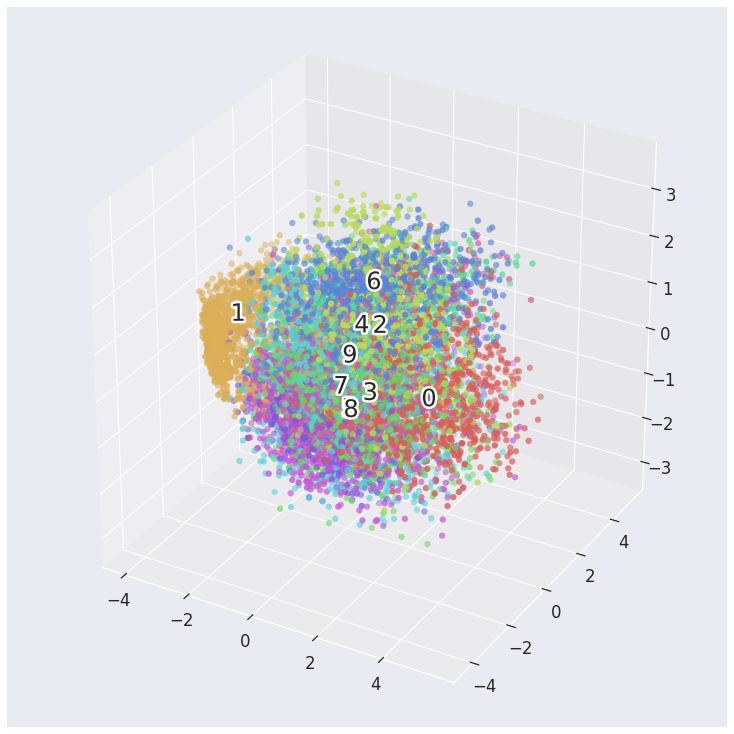

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(4, figsize=(10, 10))
ax = Axes3D(fig) # For 3D plot
fig.add_subplot(plot_PCA(z_means, y_test, axis=i, n_dims=3, plt_ax=ax)[1])

## Compute AUROC score per normal class

Here we will successively consider each digit as the normal class, train a model on it and compute the AUC, thus giving a full evaluation of its potential.

In [ ]:
from uad.diagnostic.metrics import compute_AUC_on_all

scores = compute_AUC_on_all(ConvolutionalVAE, digits_train, x_test, y_test, n_classes=10, epochs=15, latent_dim=16)
for i, elt in enumerate(scores):
  print(f"Digit: {i}: AUC = {elt}")

Digit 0, # Training examples: 5825
Epoch 1/15
46/46 [==============================] - 0s 8ms/step - loss: 370.0055 - reconstruction_loss: 369.5380 - kl_loss: 0.4675
Epoch 2/15
46/46 [==============================] - 0s 8ms/step - loss: 265.1527 - reconstruction_loss: 263.5199 - kl_loss: 1.6328
Epoch 3/15
46/46 [==============================] - 0s 8ms/step - loss: 223.3066 - reconstruction_loss: 221.8106 - kl_loss: 1.4960
Epoch 4/15
46/46 [==============================] - 0s 8ms/step - loss: 170.8517 - reconstruction_loss: 168.7606 - kl_loss: 2.0910
Epoch 5/15
46/46 [==============================] - 0s 8ms/step - loss: 135.3117 - reconstruction_loss: 132.3697 - kl_loss: 2.9421
Epoch 6/15
46/46 [==============================] - 0s 8ms/step - loss: 119.9290 - reconstruction_loss: 116.7479 - kl_loss: 3.1811
Epoch 7/15
46/46 [==============================] - 0s 8ms/step - loss: 110.8256 - reconstruction_loss: 107.5079 - kl_loss: 3.3177
Epoch 8/15
46/46 [==============================

We worked with a fully convolutional, 3-contraction blocks, (4, 4, 16) dimensional latent space. Compared to the AUC scores given in Ruff 2018: we achieve similar or strictly better performances than:
1. OC-SVM/SVDD: except for classes 4 and 8
2. KDE: everwhere
3. IF: except for digits 2, 4 and 8
4. DCAE: everywhere
5. AnoGAN: everywhere
6. Soft-bound deep SVDD: except for 2, 4, 6, 8 and 9
7. One-class deep SVDD: except for 2, 4, 6, 8, and 9.